## Notebook to create the atmospheric forcing files for ROMS input using Tim's set-up


In this notebook:
- The preprocessed ERA5 data from 1950 to 2020 is imported
- For the variables zonal and meridional wind at 10m, temperature and dewpoint temperature at 2m, total cloud cover and mean sea level pressure the data consists of 6hourly values (00:00, 06:00, 12:00, 18:00).
- For the variable total precipitation the data consists of hourly values whereof 12hourly fluxes are obtained for 6:00 and 18:00
- For the variable solar radiation the data also consists of hourly values whereof daily fluxes are obtained for 12:00
 
- For all variables the time dimension is changed to seconds since '1948-01-01T00:00:00'
- Using d2m and t2m the relative humidity (Qair) is obtained. 

- For 

In [3]:
# Import necessary packages

import dask
import numpy as np
import xarray as xr

from tqdm import tqdm
from xsimlab.monitoring import ProgressBar

dask.config.set({"array.slicing.split_large_chunks": False})


### Create atmospheric forcing for 6hourly data


The reference datum for ERA5 data is 01-01-1970 whereas roms uses 01-01-1948 as a reference

In [2]:
# Import data

era5_6hourly = xr.open_mfdataset('/Users/iriskeizer/Documents/ROMS/data/ERA5/preprocessed/6hourly/*.nc')

In [3]:
era5_6hourly = era5_6hourly.sortby('latitude') # Make sure the latitude values are ascending for both the dimension and all variables

In [4]:
# Figure out the reference time for datetime timesteps
np.datetime64(0, 'D')

numpy.datetime64('1970-01-01')

In [5]:
# Obtain seconds between '1948-01-01T00:00:00' and '1970-01-01T00:00:00'
sec_shift = np.datetime64('1948-01-01T00:00:00').astype(int)*-1 # Unit: seconds

In [6]:
# Create dimensions
lons = era5_6hourly.longitude.values
lats = era5_6hourly.latitude.values
time_1970 = era5_6hourly.time.values.astype(int)/10**9     # Create a time array of seconds since 01-01-1970
time_1948 = time_1970 + sec_shift                          # Create a time array of seconds since 01-01-1948

In [7]:
# Create variables
msl = era5_6hourly.msl.values * 0.01   # Convert from Pa to mbar
t2m = era5_6hourly.t2m.values - 273.15 # Convert from Kelvin to Celsius
tcc = era5_6hourly.tcc.values
u10 = era5_6hourly.u10.values
v10 = era5_6hourly.v10.values

In [8]:
# Compute Relative Humidity Qair from t2m and d2m using eq. 12 of DOI:10.1175/BAMS-86-2-225
L = 2.5*10**6.    # Enthalpy of vaporization at 273.15K (J/kg)
Rw = 461.5        # Gaz constant for water vapor (J/K/kg)
t2m_K = era5_6hourly.t2m.values
d2m_K = era5_6hourly.d2m.values
Qair = 100*np.exp(-L*(t2m_K - d2m_K)/(Rw*t2m_K*d2m_K))

In [18]:
# Create DataSet

# Define variables
data_vars = {'Uwind':(['time', 'lat', 'lon'], u10, 
                      {'units': 'm/s', 'long_name': 'Zonal wind at 10 meters', 'standard_name' : 'Uwind', 'time' : 'time', 'coordinates' : 'lon lat', 'fill_value' : nan}),
             'Vwind':(['time', 'lat', 'lon'], v10, 
                      {'units': 'meter second-1', 'long_name': 'surface v-wind component', 'standard_name' : 'surface_northward_wind', 'time' : 'time', 'coordinates' : 'lon lat', 'fill_value' : nan}),
             'cloud':(['time', 'lat', 'lon'], tcc, 
                      {'units': 'nondimensional', 'long_name': 'cloud fraction', 'standard_name' : 'cloud_area_fraction', 'time' : 'time', 'coordinates' : 'lon lat', 'fill_value' : nan}),
             'Pair':(['time', 'lat', 'lon'], msl, 
                     {'units': 'millibar ', 'long_name': 'surface air pressure', 'standard_name' : 'surface_air_pressure', 'time' : 'time', 'coordinates' : 'lon lat', 'fill_value' : nan}),
             'Tair':(['time', 'lat', 'lon'], t2m, 
                     {'units': 'Celsius', 'long_name': 'surface air temperature', 'standard_name' : 'surface_air_temperature', 'time' : 'time', 'coordinates' : 'lon lat', 'fill_value' : nan}),
             'Qair':(['time', 'lat', 'lon'], Qair, 
                     {'units': 'percentage', 'long_name': 'surface air relative humidity', 'standard_name' : 'surface_relative_humidity', 'time' : 'time', 'coordinates' : 'lon lat', 'fill_value' : nan}),
            }

# Define coordinates
coords = {'time':(['time'], time_1948, {'units': 'seconds since 1948-01-01 00:00:0.0', 'long_name': 'time', 'standard_name': 'time', 'calendar': 'gregorian', }),
         'lon':(['lon'], lons, {'units': 'degrees_east', 'long_name': 'Longitude', 'standard_name': 'Longitude', 'axis': 'X'}),
         'lat':(['lat'], lats, {'units': 'degrees_north', 'long_name': 'Latitude', 'standard_name': 'Latitude', 'axis': 'Y'})}



# Create Dataset
ERA5_an = xr.Dataset(data_vars = data_vars,
                    coords = coords,
                    )



In [19]:
# Save Dataset
ERA5_an.to_netcdf('/Users/iriskeizer/Documents/ROMS/data/surface forcing/ERA5_NorthAtlantic_an_ForROMS.nc')

### Create atmospheric forcing for 12hourly and daily data

In [4]:
# Import data

era5_hourly = xr.open_mfdataset('/Users/iriskeizer/Documents/ROMS/data/ERA5/preprocessed/hourly/*.nc')

In [5]:
# Shift every hour forward (such that the data is given at each hour as the sum over the next hour)
era5_hourly_shft = era5_hourly.shift(time = -1)


# Sort latitudes ascending
era5_hourly_shft = era5_hourly_shft.sortby('latitude')

# Group by 12h or by day and obtain sum
era5_12hourly = era5_hourly_shft.resample(time = '12H').sum('time')
era5_daily = era5_hourly_shft.resample(time='1D').sum('time')



In [6]:
# Figure out the reference time for datetime timesteps
np.datetime64(0, 'D')

numpy.datetime64('1970-01-01')

In [7]:
# Obtain seconds between '1948-01-01T00:00:00' and '1970-01-01T00:00:00'
sec_shift = np.datetime64('1948-01-01T00:00:00').astype(int)*-1

In [8]:
# Create dimensions
lons = era5_12hourly.longitude.values
lats = era5_12hourly.latitude.values
time_12h_1970 = era5_12hourly.time.values.astype(int)/10**9                                               # Create a time array of seconds since 01-01-1970 (ns->s)
time_d_1970 = era5_daily.time.values.astype(int)/10**9                                                    # Create a time array of seconds since 01-01-1970 (ns->s)

time_12h_1948 = time_12h_1970 + sec_shift                       # Create a time array of seconds since 01-01-1948
time_d_1948 = time_d_1970 + sec_shift

#time_12h_1948 = time_12h_1948 - 6*60*60 # Remove 6 hours to center the flux to the middle of the forcasting time (12h) instead of the beginning
#time_d_1948 = time_d_1948               # Add 12 hours to have midday values

In [9]:
# Transpose arrays

#era5_12hourly = era5_12hourly.transpose('time', 'longitude', 'latitude')
#era5_daily = era5_daily.transpose('time', 'longitude', 'latitude')

In [10]:
# Obtain fluxes rain
tp = era5_12hourly.tp

In [11]:
factor = 1000/(12*60*60)

tp = tp * factor # From m to kg/m**2/s

In [12]:
# Obtain fluxes solar radiation
ssr = era5_daily.ssr

In [13]:
factor = 24*60*60

ssr = ssr / factor

In [17]:
# Create DataSet

# Define variables
data_vars = {'rain':(['time_rain', 'lat', 'lon'], tp.values, 
                     {'units': 'kg/m**2/s', 'long_name': 'Rain fall rate', 'standard_name' : 'rain', 'time' : 'time_rain', 'coordinates' : 'lon lat', 'fill_value' : nan}),
            'swrad':(['time_swrad', 'lat', 'lon'], ssr.values, 
                    {'units': 'W/m**2', 'long_name': 'Surface solar radiation', 'standard_name' : 'swrad', 'time' : 'time_swrad', 'coordinates' : 'lon lat', 'fill_value' : nan})}

# Define coordinates
coords = {'time_rain':(['time_rain'], time_12h_1948, {'units': 'seconds since 1948-01-01 00:00:0.0', 'long_name': 'time', 'standard_name': 'time', 'calendar': 'gregorian', }),
          'time_swrad':(['time_swrad'], time_d_1948, {'units': 'seconds since 1948-01-01 00:00:0.0', 'long_name': 'time', 'standard_name': 'time', 'calendar': 'gregorian', }),
         'lon':(['lon'], lons, {'units': 'degrees_east', 'long_name': 'Longitude', 'standard_name': 'Longitude', 'axis': 'X'}),
         'lat':(['lat'], lats, {'units': 'degrees_north', 'long_name': 'Latitude', 'standard_name': 'Latitude', 'axis': 'Y'})}

# Create Dataset
ERA5_fc = xr.Dataset(data_vars = data_vars,
                    coords = coords,
                    )




In [18]:
# Save Dataset
ERA5_fc.to_netcdf('/Users/iriskeizer/Documents/ROMS/data/surface forcing/ERA5_NorthAtlantic_fc_ForROMS.nc')

In [33]:
ERA5_fc.isel(time_rain=0).rain.min()

<xarray.DataArray 'rain' ()>
array(1.0779196e-10, dtype=float32)
Coordinates:
    time_rain  float64 6.316e+07

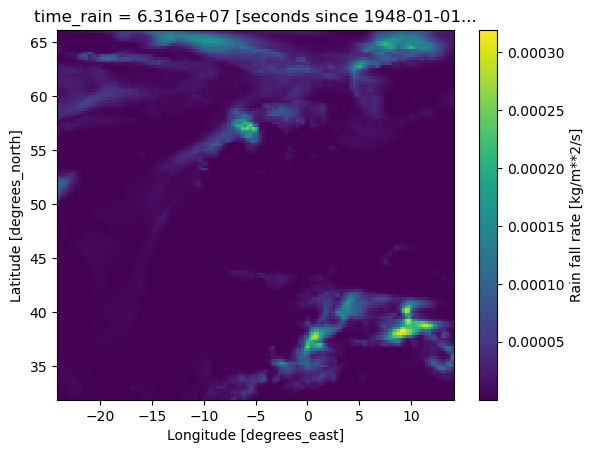

In [27]:
ERA5_fc.isel(time_rain=0).rain.plot()